Using cache found in C:\Users\Dhaarna/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-7-19 Python-3.9.12 torch-2.0.1+cpu CPU

Fusing layers... 
YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients
Adding AutoShape... 


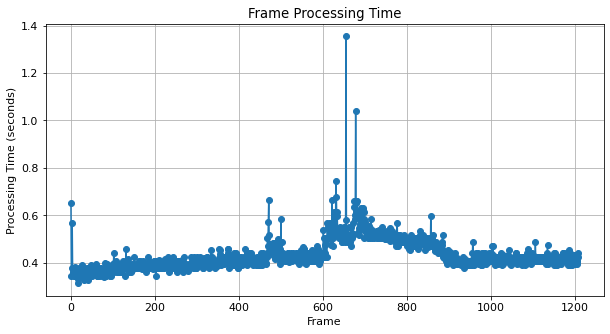

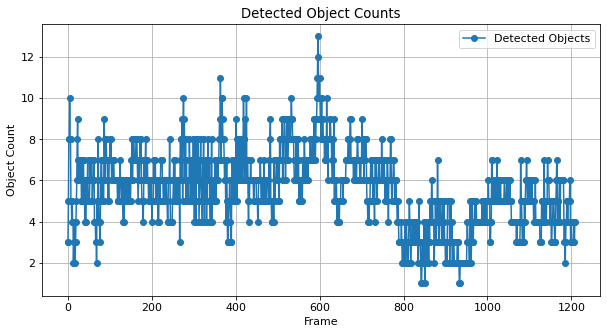

In [3]:
import cv2
import numpy as np
import torch
import torchvision
import math
import matplotlib.pyplot as plt
import time
import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)


# Load the YOLOv5m model
model_path = 'yolov5m.pt'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
yolo_model = torch.hub.load("ultralytics/yolov5", "yolov5m")
yolo_model.to(device)
yolo_model.eval()# Set the YOLO model to evaluation mode for faster inference
frame_processing_times = []
detected_object_counts = []
tracked_object_counts = []

# Loading the video and converting it to .mp4v
path_input_video = cv2.VideoCapture('E:/Project/bdd100k_videos_train_00/bdd100k/videos/train/01ca43f9-d9cae3f4.mov')
path_output_video = 'E:/Project/bdd100k_videos_train_00/bdd100k/videos/train/01ca43f9-d9cae3f4.mp4'
width, height = 1280, 720
Output_Video = cv2.VideoWriter(path_output_video, cv2.VideoWriter_fourcc(*'mp4v'), 20, (width, height))
enable_track = False

#class
yolo_classes = [
    'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
    'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella'
]


def transparent_overlay_check(Overlay_background, Foreground_overlay, angle, x, y, objSize=50):
    original_frame = Overlay_background.copy()
    Foreground_overlay = cv2.resize(Foreground_overlay, (objSize, objSize))


    # Extract the dimensions and channel count of the foreground
    check_rows, check_cols, channels = Foreground_overlay.shape

    # Determine the midpoint of the foreground
    center_x = int(check_cols / 2)
    center_y = int(check_rows / 2)

    # Generate the rotation matrix for the desired angle
    M = cv2.getRotationMatrix2D((center_x, center_y), angle, 1)
    
    # Apply the rotation transformation to the foreground
    Foreground_overlay = cv2.warpAffine(Foreground_overlay, M, (check_cols, check_rows))

    # Merge the rotated foreground with the background based on alpha values
    for row in range(check_rows):
        for col in range(check_cols):
            if x + row < Overlay_background.shape[0] and y + col < Overlay_background.shape[1]:
                alpha = Foreground_overlay[row, col, 3] / 255.0
                Overlay_background[x + row, y + col] = alpha * Foreground_overlay[row, col, :3] + (1 - alpha) * Overlay_background[x + row, y + col]

    # Return the combined image
    result = Overlay_background
    return result


def simulation_of_object(Overlay_background, object_class, x, y):
    # Retrieve the object image based on the given class
    image_of_object = cv2.imread(f'assets/{object_class}.png', cv2.IMREAD_UNCHANGED)
    if image_of_object is None:
        return Overlay_background
    # Merge the object image with the background at specified coordinates
    Overlay_background[y:y+100, x:x+100] = transparent_overlay_check(Overlay_background[y:y+100, x:x+100], image_of_object, 0, 0, 0)
    return Overlay_background

def overlay_car(Overlay_background):
    
    # Load the car overlay image
    overlay_img = cv2.imread('MyCar.png', cv2.IMREAD_UNCHANGED)
    
    # Determine overlay image dimensions
    check_rows, check_cols, _ = overlay_img.shape
    x = 550
    y = Overlay_background.shape[0] - 200
    
    # Merge the car overlay with the background at the specified location
    overlay_img = transparent_overlay_check(Overlay_background[y:y+check_rows, x:x+check_cols], overlay_img, 0, 0, 0, objSize=250)
    Overlay_background[y:y+check_rows, x:x+check_cols] = overlay_img

    return Overlay_background


def object_bev_plot(transformed_image_with_centroids, source_points ,destination_points , objs_):
    
    # Compute perspective transformation matrix
    M = cv2.getPerspectiveTransform(source_points, destination_points)
    persObjs = []
    
    # Process each object's coordinates and ID
    for obj_ in objs_:
        if obj_:
            # Convert centroid to numpy format
            centroid_coordinates = np.array([list(obj_[0])], dtype=np.float32)

            # Transform the centroid coordinates to new perspective
            transformed_coordinates = cv2.perspectiveTransform(centroid_coordinates.reshape(-1, 1, 2), M)
            transformed_coordinates_ = tuple(transformed_coordinates[0][0].astype(int))                                                       

            # Mark the transformed centroid with a circle and annotate with class information
            cv2.circle(transformed_image_with_centroids, transformed_coordinates_, radius=3, color=(0, 255, 0), thickness=-1)
            cv2.circle(transformed_image_with_centroids, transformed_coordinates_, radius=12, color=(255, 255, 255), thickness=1)
            class_text = f"Class: {obj_[1]}"
            cv2.putText(transformed_image_with_centroids, class_text, (transformed_coordinates_[0] + 10, transformed_coordinates_[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
            persObjs.append([transformed_coordinates_, obj_[1]])

                                                          
                                                                                                                  
    return transformed_image_with_centroids, persObjs
                                      
                                                                                                                                                                     
# Pair current objects with their closest counterparts from the previous frame using Euclidean distance
def tracking_and_distance_details(objects_curr, objects_prev, threshold=50):
    object_tracking = {}
    id_tracking = 0
    for obj1 in objects_curr:
        for obj2 in objects_prev:
            dist = math.hypot(obj2[0][0] - obj1[0][0], obj2[0][1] - obj1[1])
            if dist < threshold:
                object_tracking[id_tracking] = obj1
                id_tracking += 1
    return object_tracking

# Set inference batch size
size_of_batch = 4
frames = []
frame_count = 0
centroid_prev_frame = []
object_tracking = {}
id_tracking = 0


# Iteratively process the video frames
while True:
    # Capture the next frame from video input
    success, frame = path_input_video.read()
    start_time = time.time()

    # Terminate loop if end of video is reached
    if not success:
        break

    # Resize the captured frame and add to batch
    if frame is not None:
        frame = cv2.resize(frame, (width, height))
        frames.append(frame)
        frame_count += 1

        # Infer on the batch if it's full
        if len(frames) == size_of_batch:
            results = yolo_model(frames, size=320)

            for idx, frame in enumerate(frames):
                detections = results.pred[idx]

                # Filter out detections below confidence threshold and apply non-max suppression
                detections = detections[detections[:, 4] >= 0.3]  # Apply score threshold
                detections = detections[torchvision.ops.nms(detections[:, :4], detections[:, 4], iou_threshold=0.5)]  # Apply non-max suppression

    else:
        continue

    # Detect objects in the current frame
    results = yolo_model(frame, size=160)
    detections = results.pred[0]
    # Initialize black images to overlay visualizations
    image_ = np.zeros((height, width, 3), dtype=np.uint8)
    simulated_image = image_.copy()
    transformed_image_with_centroids = image_.copy()
    transformed_image_to_sim = image_.copy()
    simObjs = image_.copy()
    objs = []
    centroid_curr_frame = []

    # Loop through detections to draw bounding boxes and gather object centroids                       
    for detect in detections:
        xmin = detect[0]
        ymin = detect[1]
        xmax = detect[2]
        ymax = detect[3]
        score = detect[4]
        class_id = detect[5]
        centroid_x = int(xmin + xmax) // 2
        centroid_y = int(ymin + ymax) // 2

        # Filter detections based on class ID and score
        if int(class_id) in [0, 1, 2, 3, 5, 7] and score >= 0.3:
            # Annotate detected objects with bounding boxes and labels
            color = (0, 0, 255)
            object_label = f"{yolo_classes[int(class_id)]}: {score:.2f}"
            cv2.rectangle(frame, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color, 2)
            cv2.putText(frame, object_label, (int(xmin), int(ymin) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 1)
            # Store object centroids and class labels
            centroid_curr_frame.append([(centroid_x, centroid_y), yolo_classes[int(class_id)]])
            if not enable_track:
                objs.append([(centroid_x, centroid_y), yolo_classes[int(class_id)]])
    
    # Count detected and tracked objects
    detected_count = len(detections)
    tracked_count = len(object_tracking)
    detected_object_counts.append(detected_count)
    tracked_object_counts.append(tracked_count)

    
    # Handle object tracking using centroids from the current and previous frames                        
    if enable_track:
        # Associate objects from current and previous frames if frame count is low
        if frame_count <= 2:
            for point_1, class_id in centroid_curr_frame:
                for point_2, class_id in centroid_prev_frame:
                    dist = math.hypot(point_2[0] - point_1[0], point_2[1] - point_1[1])
                    if dist < 50:
                        object_tracking[id_tracking] = point_1, class_id
                        id_tracking += 1
        # For subsequent frames, update or remove tracked objects based on their proximity                
        else:
            object_tracking_copy = object_tracking.copy()
            for obj_id, point_2 in object_tracking_copy.items():
                object_exists = False
                for point_1, class_id in centroid_curr_frame:
                    dist = math.hypot(point_2[0][0] - point_1[0], point_2[0][1] - point_1[1])
                    if dist < 20:
                        object_tracking[obj_id] = point_1, class_id
                        object_exists = True
                        continue
                if not object_exists:
                    object_tracking.pop(obj_id)

        # Mark the tracked objects on the frame
        for obj_id, point_1 in object_tracking.items():
            cv2.circle(frame, point_1[0], 3, (0, 255, 255), -1)
                                                                                                                      
            if enable_track:
                objs.append([point_1[0], point_1[1]])
        # Store current frame's centroids for the next iteration
        centroid_prev_frame = centroid_curr_frame.copy()

    # Setting up the Bird's Eye View Transformation
    # Define source points in the original frame
    source_points = np.float32([(10, 720), (530, 400), (840, 400), (1270, 720)])
    # Define destination points for the bird's eye view
    destination_points = np.float32([(370, 720), (150, 0), (1130, 0), (900, 720)])
    
    # Transform and plot objects on the bird's eye view perspective
    transformed_image_with_centroids, persObjs_ = object_bev_plot(transformed_image_with_centroids, source_points ,destination_points , objs)

    # Simulate detected objects in the bird's eye view
    for persObj_ in persObjs_:
        simObjs = simulation_of_object(transformed_image_to_sim, persObj_[1], persObj_[0][0], persObj_[0][1])

    # Overlay a car image onto the simulated objects frame
    simulated_image = overlay_car(simObjs)

    # Write the simulated image to the output video
    Output_Video.write(simulated_image)

    # Display the current frame, simulated objects, and the transformed frame
    cv2.imshow("Original Frame", frame)
    cv2.imshow("Simulated Bird's Eye View", simulated_image)
    cv2.imshow("Transformed Bird's Eye View", transformed_image_with_centroids)
    
    end_time = time.time()
    processing_time = end_time - start_time
    frame_processing_times.append(processing_time)


    # Exit video loop if 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Plot processing time per frame
plt.figure(figsize=(10, 5))
plt.plot(frame_processing_times, marker='o')
plt.xlabel('Frame')
plt.ylabel('Processing Time (seconds)')
plt.title('Frame Processing Time')
plt.grid()
plt.show()

# Plot detected and tracked object counts
plt.figure(figsize=(10, 5))
plt.plot(detected_object_counts, marker='o', label='Detected Objects')
plt.xlabel('Frame')
plt.ylabel('Object Count')
plt.title('Detected Object Counts')
plt.legend()
plt.grid()
plt.show()

# Cleanup: release video input and output handles and close all OpenCV windows
path_input_video.release()
Output_Video.release()
cv2.destroyAllWindows()